## Step #1: Data Import and Initial Exploration

### Overview
In this step, we import the Ames housing dataset and perform an initial inspection to understand its structure. This includes loading the training and test data, previewing the first few rows, reviewing summary statistics for the target variable (`SalePrice`), and identifying variables with the highest number of missing values.

### Code Purpose
- Load the training and test CSV files using Pandas  
- Display dataset dimensions  
- Preview the first rows of the training dataset  
- Summarize the distribution of `SalePrice`  
- Identify columns with the most missing values to guide data cleaning

### Output Analysis
The training dataset contains **1,460 observations and 81 features**, while the test dataset includes **1,459 observations and 80 features**, confirming that `SalePrice` is only present in the training set since it is the target variable to predict.

A preview of the first rows shows a mix of numeric and categorical variables describing property characteristics such as lot size, zoning, building style, and construction details. The summary statistics for `SalePrice` indicate:

- **Mean** price of approximately \$180,921  
- **Median** price of \$163,000, slightly below the mean (suggesting right skew)  
- **Minimum** price of \$34,900 and **maximum** of \$755,000  

This confirms a wide range of housing values in Ames, Iowa, and hints at a skewed distribution, which is common in real estate data.

The missing value summary reveals that some columns have substantial missing data, especially:

- `PoolQC`, `MiscFeature`, `Alley`, `Fence`
- Several basement and garage-related fields

Most of these missing values relate to optional home features rather than errors. This insight will guide our cleaning strategy, such as assigning “None” where a feature does not exist or imputing values where appropriate in later steps.


In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("train shape:", train.shape)
print("test shape:", test.shape)

display(train.head(5))

display(train["SalePrice"].describe(percentiles=[0.25,0.5,0.75]).to_frame().T)

display(train.isnull().sum().sort_values(ascending=False).head(20).to_frame("n_missing"))


train shape: (1460, 81)
test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.19589,79442.502883,34900.0,129975.0,163000.0,214000.0,755000.0


,n_missing
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageFinish,81
GarageType,81


##  Step #2: Distribution of SalePrice and Log-Transformed SalePrice

### Overview
This step examines the distribution of the target variable, `SalePrice`, and applies a logarithmic transformation to assess whether it improves normality. Understanding the distribution of the target variable is important for selecting appropriate modeling techniques and evaluation metrics.

### Code Purpose
- Plot the raw distribution of home sale prices
- Plot the distribution after applying a natural log transformation
- Compute skewness before and after log transformation to quantify improvement

### Output Analysis
The left histogram shows that **SalePrice is right-skewed**, with most properties priced between approximately \$100,000 and \$300,000, and a long tail of high-value homes reaching above \$700,000. This skewness is confirmed numerically, with a **skew value of ~1.88**, indicating substantial deviation from normality.

The log-transformed distribution on the right appears much more symmetric and bell-shaped. The skewness after transformation decreases dramatically to **~0.12**, indicating that the log transformation results in a distribution close to normal.

This transformation is beneficial because:

- Many machine learning algorithms perform better when the target variable is approximately normally distributed
- It stabilizes variance, making errors more balanced across price ranges
- The Kaggle competition evaluation metric (RMSE on log prices) aligns with this approach

As a result, we will model `LogSalePrice` rather than raw `SalePrice` in later analysis steps.


Skew (raw): 1.8828757597682129
Skew (log): 0.12133506220520406


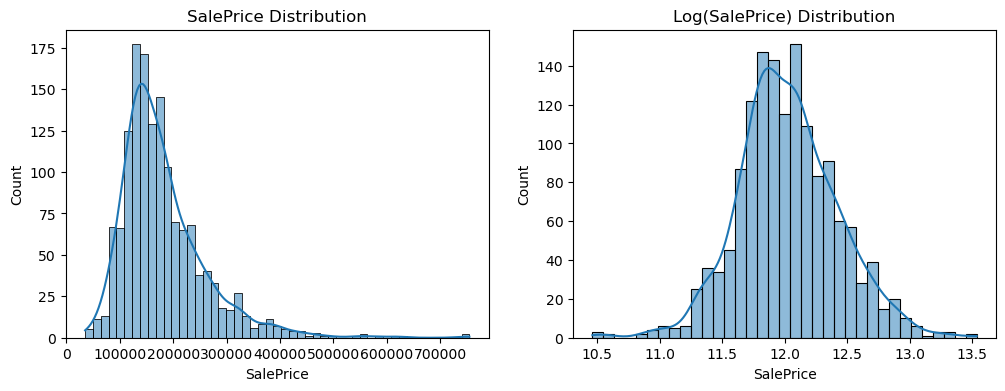

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(train["SalePrice"], kde=True, ax=axes[0])
axes[0].set_title("SalePrice Distribution")

sns.histplot(np.log(train["SalePrice"]), kde=True, ax=axes[1])
axes[1].set_title("Log(SalePrice) Distribution")

print("Skew (raw):", train["SalePrice"].skew())
print("Skew (log):", np.log(train["SalePrice"]).skew())



##  Step #3: Data Cleaning and Log Transformation

### Overview
This step prepares the dataset for modeling by handling missing values and creating a log-transformed version of the target variable (`SalePrice`). Proper data cleaning ensures that machine learning algorithms can run without errors and that numerical inputs are meaningful.

### Code Purpose
- Create a working copy of the training dataset  
- Identify numeric and categorical columns  
- Impute missing values:
  - Numeric columns → filled with the median  
  - Categorical columns → filled with the string `"None"` to indicate absence of a feature  
- Add a new column containing the log-transformed sale price (`LogSalePrice`)  
- Verify that all missing values have been addressed  

### Output Analysis
All missing values were successfully handled, as indicated by:

"Remaining missing values: 0"

This confirms that the dataset is now complete and ready for downstream modeling steps. Replacing numeric missing values with the median preserves distribution characteristics without being heavily influenced by outliers, while assigning `"None"` to categorical features appropriately captures cases where a property lacks amenities such as a fence, alley access, or masonry veneer.

The preview of columns `SalePrice` and `LogSalePrice` shows that the log transformation has been applied correctly. We will use `LogSalePrice` as the target variable in our prediction models to account for the previously observed skew in home prices and to align with standard evaluation metrics for this dataset.


In [3]:
train_clean = train.copy()

numeric_vars = train_clean.select_dtypes(include=[np.number]).columns
categorical_vars = train_clean.select_dtypes(include=["object"]).columns

for col in numeric_vars:
    train_clean[col] = train_clean[col].fillna(train_clean[col].median())

for col in categorical_vars:
    train_clean[col] = train_clean[col].fillna("None")

train_clean["LogSalePrice"] = np.log(train_clean["SalePrice"])

print("Remaining missing values:", train_clean.isnull().sum().sum())
train_clean[["SalePrice","LogSalePrice"]].head()


Remaining missing values: 0


,SalePrice,LogSalePrice
0,208500,12.247694
1,181500,12.109011
2,223500,12.317167
3,140000,11.849398
4,250000,12.429216


##  Step #4: Correlation Analysis of Numerical Features

### Overview
This step examines how numerical features in the Ames housing dataset relate to the target variable, `SalePrice`. Understanding these relationships helps identify which features are most predictive and should receive greater focus in the modeling process.

### Code Purpose
- Compute the correlation between each numeric variable and `SalePrice`
- Display the top 15 most strongly correlated features
- Visualize pairwise correlations across numeric variables using a heatmap

### Output Analysis
The correlation results highlight several key features that have strong positive relationships with home sale prices, including:

- **OverallQual (≈ 0.79)** — the overall material and finish quality of the house
- **GrLivArea (≈ 0.71)** — above-ground living area in square feet
- **GarageCars & GarageArea (≈ 0.64–0.62)** — size and capacity of the garage
- **TotalBsmtSF & 1stFlrSF (≈ 0.61)** — total basement and first-floor square footage
- **FullBath, TotRmsAbvGrd, YearBuilt** — indicators of home size, layout, and age

As expected, **LogSalePrice** is highly correlated with `SalePrice`, confirming the validity of the transformed target variable.

The heatmap visualizes broader correlations among numeric variables. Warmer colors represent strong positive correlations (e.g., `GrLivArea` and `TotRmsAbvGrd`), while cooler tones indicate weaker or negative relationships. The diagonal reflects perfect correlation of each variable with itself.

These findings corroborate common real-estate intuition: higher-quality, larger, and more modern homes command higher prices. This correlation structure will help guide feature selection and model development in later steps.


SalePrice       1.000000
LogSalePrice    0.948374
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
GarageYrBlt     0.466754
Name: SalePrice, dtype: float64


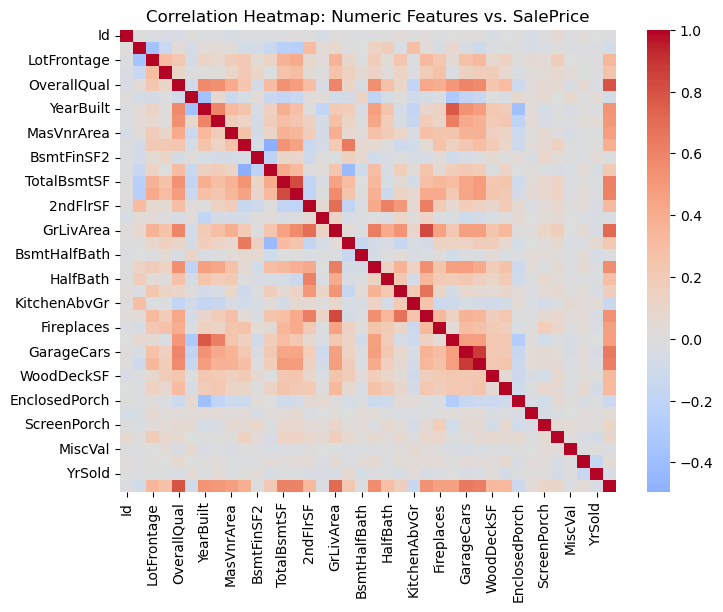

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = train_clean.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False).head(15)
print(corr)

plt.figure(figsize=(8,6))
sns.heatmap(train_clean[numeric_vars].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap: Numeric Features vs. SalePrice")
plt.show()


##  Step #5: Relationship Between Key Predictors and Sale Price

### Overview
This step visualizes the relationship between home sale prices and two influential features: above-ground living area (`GrLivArea`) and neighborhood. These plots help confirm trends observed in the correlation analysis and illustrate how physical size and location drive housing values.

### Code Purpose
- Create a scatterplot of `GrLivArea` vs. `SalePrice` to visualize the effect of square footage on home prices  
- Create a boxplot of `SalePrice` grouped by the top 10 neighborhoods ranked by median price  
- Highlight distribution differences and potential outliers in both relationships

### Output Analysis
The scatterplot on the left shows a strong positive relationship between **above-ground living area** and **sale price**. Larger homes tend to sell for higher prices, and the upward trend is consistent with real estate expectations. A few extreme outliers are present, particularly very large homes that do not command proportionally higher prices, which may indicate unusual properties or special sale circumstances.

The boxplot on the right illustrates how **neighborhood significantly influences housing values**. Higher-priced neighborhoods exhibit higher medians and wider price distributions, whereas more modest neighborhoods show lower and more compact price ranges. This confirms that **location is a major determinant of property value**, and incorporating neighborhood information is essential for accurate predictions.

Together, these visualizations support our modeling strategy by identifying size and neighborhood as key predictors and showcasing variation in real estate pricing within Ames.


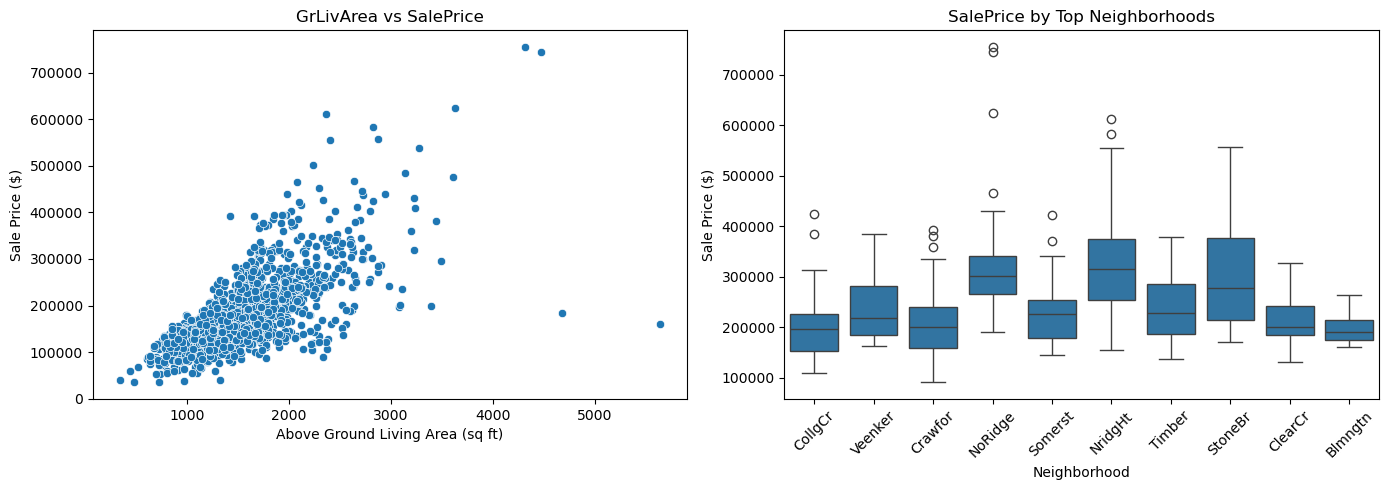

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.scatterplot(x=train_clean["GrLivArea"], y=train_clean["SalePrice"], ax=axes[0])
axes[0].set_title("GrLivArea vs SalePrice")
axes[0].set_xlabel("Above Ground Living Area (sq ft)")
axes[0].set_ylabel("Sale Price ($)")

top_neighborhoods = train_clean.groupby("Neighborhood")["SalePrice"].median().sort_values().tail(10).index

sns.boxplot(
    x="Neighborhood",
    y="SalePrice",
    data=train_clean[train_clean["Neighborhood"].isin(top_neighborhoods)],
    ax=axes[1]
)
axes[1].set_title("SalePrice by Top Neighborhoods")
axes[1].set_xlabel("Neighborhood")
axes[1].set_ylabel("Sale Price ($)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


##  Step #6: Feature Encoding and Train-Validation Split

### Overview
Before training our predictive model, we prepare the dataset by converting categorical variables into numerical format and splitting the data into training and validation sets. These steps ensure the model can learn effectively and that we can objectively evaluate its performance.

### Code Purpose
- Create feature matrix `X` and target variable `y`, using the log-transformed sale price (`LogSalePrice`)
- Convert categorical variables into numeric dummy variables using one-hot encoding
  - `drop_first=True` avoids multicollinearity by removing one category from each encoded feature
- Split the data into training (80 percent) and validation (20 percent) subsets
  - Ensures that model performance can be evaluated on unseen data

### Output Analysis
The resulting shapes:

X_train: 1168 rows × 261 features
X_val: 292 rows × 261 features


confirm that the data has been successfully processed for modeling. After one-hot encoding, the dataset now includes **261 numerical predictors**, reflecting the original numeric features plus encoded categorical variables. The consistent feature count across training and validation sets ensures compatibility during model training and evaluation.

This step establishes the foundation for building machine-learning models by providing a clean, numerical feature matrix and a properly defined target variable.


In [6]:
from sklearn.model_selection import train_test_split

train_model = train_clean.copy()

X = train_model.drop(["SalePrice","LogSalePrice"], axis=1)
y = train_model["LogSalePrice"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_val.shape


((1168, 261), (292, 261))

##  Step #7: Baseline Linear Regression Model and RMSE Evaluation

### Overview
In this step, we train a baseline linear regression model to predict the log-transformed sale price of homes and evaluate its performance using Root Mean Squared Error (RMSE). This serves as our initial benchmark before exploring more advanced modeling techniques.

### Code Purpose
- Initialize and fit a **LinearRegression** model using the training data
- Generate predictions on the validation set
- Calculate the RMSE between predicted and actual log sale prices
  - RMSE measures the average prediction error in log-price units and is consistent with the evaluation metric for this dataset

### Output Analysis
The model produced an RMSE of: 0.1733

This value represents the average error between predicted and actual log-scaled home prices. Given that this is a simple baseline model without feature engineering or regularization, a performance of approximately **0.17 RMSE** is reasonable for the Ames housing dataset.  

This result indicates that the model captures general pricing patterns but leaves room for improvement. In later steps, we can apply techniques such as tree-based models to better capture non-linear relationships and reduce overfitting.



In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_val)

rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred))
rmse_lr


np.float64(0.1733018578714101)

##  Step #8: Residual Analysis for Linear Regression Model

### Overview
After fitting the baseline linear regression model, we visualize the model's residuals (prediction errors) to evaluate how well the model captures the underlying structure in the data. Residual analysis helps assess model fit and diagnose issues such as non-linearity or heteroscedasticity.

### Code Purpose
- Compute residuals (actual − predicted log sale prices)
- Create a scatterplot of residuals versus predicted values
- Display summary statistics of residuals to quantify their behavior

### Output Analysis
The residual plot shows that most points are tightly clustered around the horizontal zero line, indicating that the model's predictions are generally accurate without systematic bias. The **mean residual is approximately 0.003**, very close to zero, further confirming unbiased predictions on average.

However, the spread of residuals slightly increases for higher predicted values, suggesting mild **heteroscedasticity** — the model becomes less precise for more expensive properties. This pattern is typical for housing price data, where luxury homes can vary widely in features not fully captured by linear models.

The summary statistics show:

- Standard deviation of residuals ≈ **0.174**, consistent with the RMSE
- A few larger positive residuals (max ≈ **1.97**), indicating rare cases where the model underestimates high-priced homes

Overall, the linear model performs reasonably well but does not fully model price variation at the upper end of the market, motivating further improvement with more flexible or regularized methods in future steps.


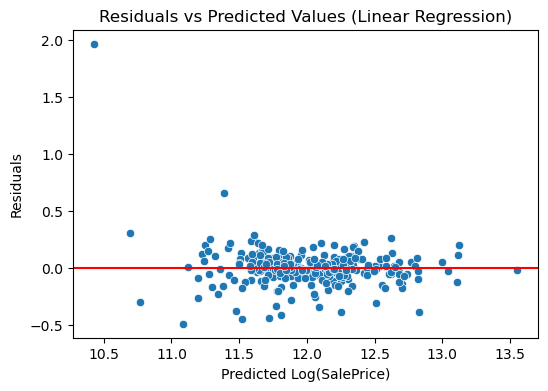

count    292.000000
mean       0.003256
std        0.173569
min       -0.487005
25%       -0.059910
50%        0.004874
75%        0.063133
max        1.965926
Name: LogSalePrice, dtype: float64

In [8]:
residuals = y_val - y_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red")
plt.xlabel("Predicted Log(SalePrice)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values (Linear Regression)")
plt.show()

residuals.describe()
